In [1]:
import torch
import torch.nn as nn
from torch.nn import Linear, Conv2d, BatchNorm1d, BatchNorm2d, PReLU, Sequential, Module
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
from model import EmotionClassifier
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device("cpu")

class_labels = ['happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear']

model = EmotionClassifier().to(device)
model.load_state_dict(torch.load('best_RAF.pth', map_location=device))
model.eval()

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def classify_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    image_array = np.array(image)
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = F.softmax(outputs, dim=1)
    scores = probabilities.cpu().numpy().flatten()
    rounded_scores = [round(score, 2) for score in scores]
    return rounded_scores, image, image_array, image_tensor

# test_path = 'dataset/vali/img381_happiness.jpg'
# test_path = 'dataset/vali/img005_surprise.jpg'
test_path = 'dataset/vali/img113_fear.jpg'
scores, image, image_array, image_tensor = classify_image(test_path)
print(scores)

[0.12, 0.73, 0.04, 0.02, 0.02, 0.08]


In [3]:
# approach with self defined hook functions: https://towardsdatascience.com/grad-cam-in-pytorch-use-of-forward-and-backward-hooks-7eba5e38d569
# defines two global scope variables to store our gradients and activations
gradients = None
activations = None

def backward_hook(model, grad_input, grad_output):
  global gradients # refers to the variable in the global scope
  print('Backward hook running...')
  gradients = grad_output
  # In this case, we expect it to be torch.Size([batch size, 1024, 8, 8])
  print(f'Gradients size: {gradients[0].size()}') 
  # We need the 0 index because the tensor containing the gradients comes
  # inside a one element tuple.

def forward_hook(model, args, output):
  global activations # refers to the variable in the global scope
  print('Forward hook running...')
  activations = output
  # In this case, we expect it to be torch.Size([batch size, 1024, 8, 8])
  print(f'Activations size: {activations.size()}')
  
# backward_hook = model.bn5.register_full_backward_hook(backward_hook, prepend=False)
# forward_hook = model.bn5.register_forward_hook(forward_hook, prepend=False)

img_tensor = transform(image)
model(img_tensor.unsqueeze(0))
model.backward()

backward_hook.remove()
forward_hook.remove()

AttributeError: 'EmotionClassifier' object has no attribute 'backward'

BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Shape of image array: (64, 64, 3)
<class 'numpy.ndarray'>
(64, 64, 3)


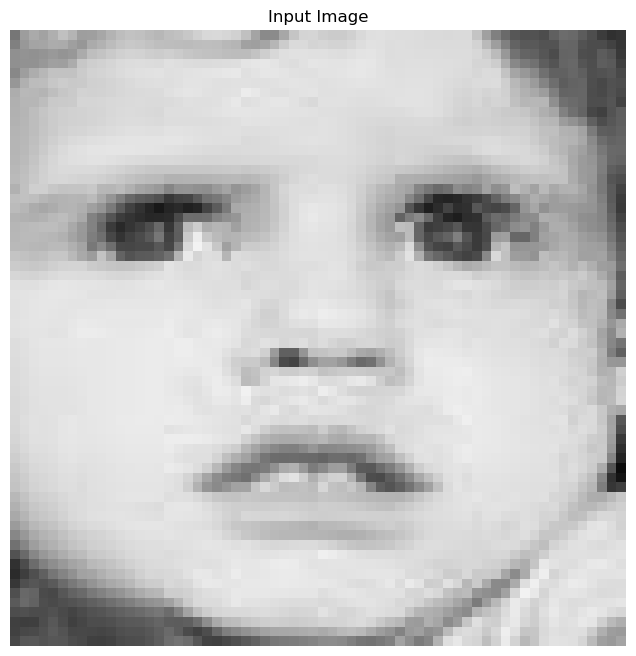

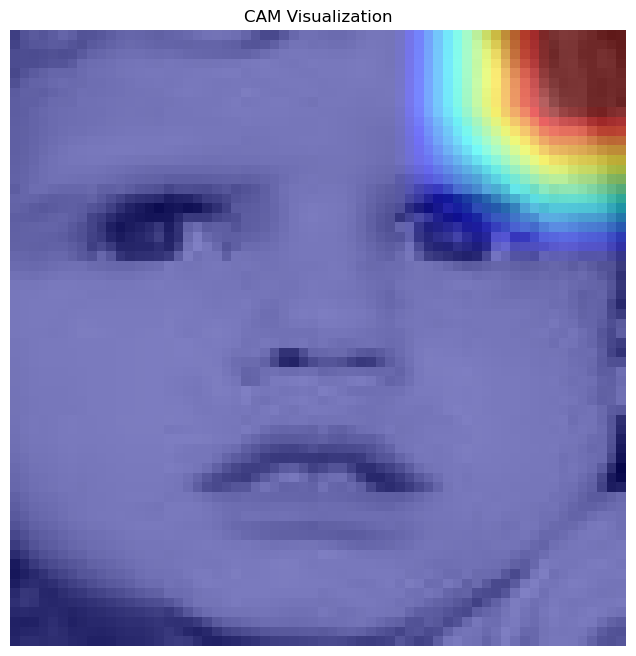

In [4]:
# approach with pytorch Grad-CAM: https://github.com/jacobgil/pytorch-grad-cam?tab=readme-ov-file

print(model.bn5)
target_layers = [model.bn5]

# convert the input image to np.float32
image_array = image_array.astype(np.float32)

# normalize the input image to the range [0, 1]
image_array /= 255.0

# Print the shape of the array
print("Shape of image array:", image_array.shape)

# construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers)
print(cam)

targets = [ClassifierOutputTarget(1)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=image_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(image_array, grayscale_cam, use_rgb=True)

print(type(visualization))
print(visualization.shape)

# Display the input image
plt.figure(figsize=(8, 8))
plt.imshow(image_array)
plt.title('Input Image')
plt.axis('off')
plt.show()

# Display the CAM visualization
plt.figure(figsize=(8, 8))
plt.imshow(visualization)
plt.title('CAM Visualization')
plt.axis('off')
plt.show()


In [ ]:
# Grad-CAM with Torchcam: https://github.com/frgfm/torch-cam/blob/main/README.md

In [ ]:
# Landmarks

In [ ]:
# Bounding Box
# overlay Results

In [ ]:
# Webcam access
